# Habitable Planet Hunter: Exploratory Data Analysis (EDA)
**Author:** Krishna Sikheriya (Krishna200608)  
**Task:** Issue #120 - Perform EDA on Imputed Data

---

### **Objective**
To understand the distribution, correlations, and physical relationships of exoplanets in our dataset. We will first generate a clean dataset using MICE imputation (to handle missing values physically) and then visualize the results to identify potential habitable candidates.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imputation Libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='viridis')
plt.rcParams['figure.figsize'] = (12, 6)

## **Part 1: Data Preparation (Imputation)**
Before analyzing, we must fix the missing data. We use the **"Golden Version" MICE Pipeline** that enforces physical constraints (no negative mass/radius).

In [12]:
# 1. Load Data (Adjust path relative to 'tasks/EDA/submissions/User/')
try:
    df = pd.read_csv('../data/full_data.csv')
except FileNotFoundError:
    # Fallback if running locally in a different folder
    df = pd.read_csv('full_data.csv')

# 2. Define Approved Features
approved_features = [
    'P_MASS', 'P_RADIUS', 'P_DENSITY', 'P_GRAVITY', 'P_ESCAPE', 'P_TYPE',
    'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_INCLINATION',
    'P_OMEGA', 'P_PERIASTRON', 'P_APASTRON', 'P_IMPACT_PARAMETER', 'P_HILL_SPHERE',
    'S_MASS', 'S_RADIUS', 'S_LUMINOSITY', 'S_TEMPERATURE', 'S_AGE',
    'S_METALLICITY', 'S_LOG_G', 'S_TYPE', 'S_MAG', 'S_DISC', 'S_MAGNETIC_FIELD',
    'S_SNOW_LINE', 'S_TIDAL_LOCK', 'P_DETECTION', 'P_DISTANCE'
]

# 3. Filter & Clean Empty Columns
existing_cols = [col for col in approved_features if col in df.columns]
df_selected = df[existing_cols].copy()
empty_cols = df_selected.columns[df_selected.isnull().all()].tolist()
if empty_cols:
    df_selected = df_selected.drop(columns=empty_cols)

# 4. Build & Run Pipeline
cat_cols = df_selected.select_dtypes(include=['object']).columns.tolist()
num_cols = df_selected.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', IterativeImputer(max_iter=20, random_state=42, min_value=0))]), num_cols),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OrdinalEncoder())]), cat_cols)
], verbose_feature_names_out=False)

data_imputed = preprocessor.fit_transform(df_selected)
df_clean = pd.DataFrame(data_imputed, columns=preprocessor.get_feature_names_out(), index=df_selected.index)

# Safety Lock: No negative physics
df_clean[num_cols] = df_clean[num_cols].clip(lower=0)
print("Data Imputed & Cleaned. Ready for EDA.")

Data Imputed & Cleaned. Ready for EDA.


## **Part 2: Exploratory Data Analysis (EDA)**

### **1. Univariate Analysis: The Size of Worlds**
Let's look at the distribution of Planet Radius. Are most planets Earth-sized, or Gas Giants?

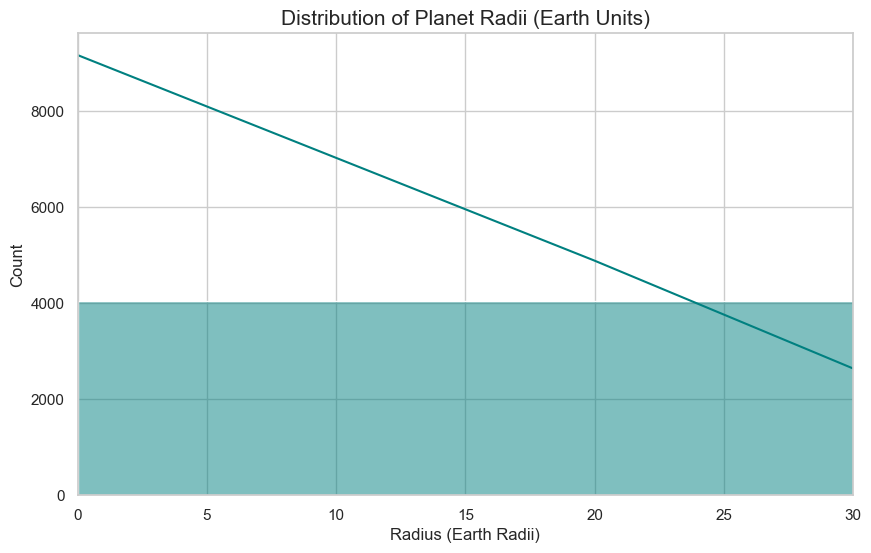

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['P_RADIUS'], bins=50, kde=True, color='teal')
plt.title('Distribution of Planet Radii (Earth Units)', fontsize=15)
plt.xlabel('Radius (Earth Radii)')
plt.xlim(0, 30)
plt.show()

### **2. Bivariate Analysis: Mass-Radius Relationship**
This is the most famous plot in exoplanet science. It tells us about the **density** and **composition** of planets. 
* **Rocky Planets:** Follow a steep curve (adding mass doesn't change radius much).
* **Gas Giants:** Flatter curve (adding mass increases density more than size).

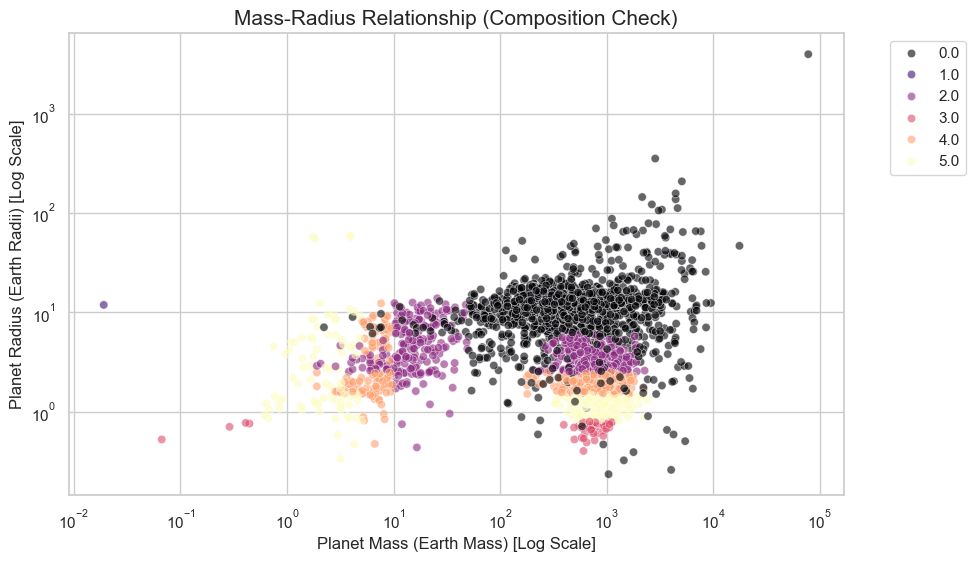

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='P_MASS', y='P_RADIUS', data=df_clean, alpha=0.6, hue='P_TYPE', palette='magma')

# Log scale is essential because Mass varies from 0.1 to 10,000 Earths
plt.xscale('log')
plt.yscale('log')

plt.title('Mass-Radius Relationship (Composition Check)', fontsize=15)
plt.xlabel('Planet Mass (Earth Mass) [Log Scale]')
plt.ylabel('Planet Radius (Earth Radii) [Log Scale]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### **3. The Habitable Zone Check**
Are there planets with temperatures similar to Earth? (roughly 200K to 320K).

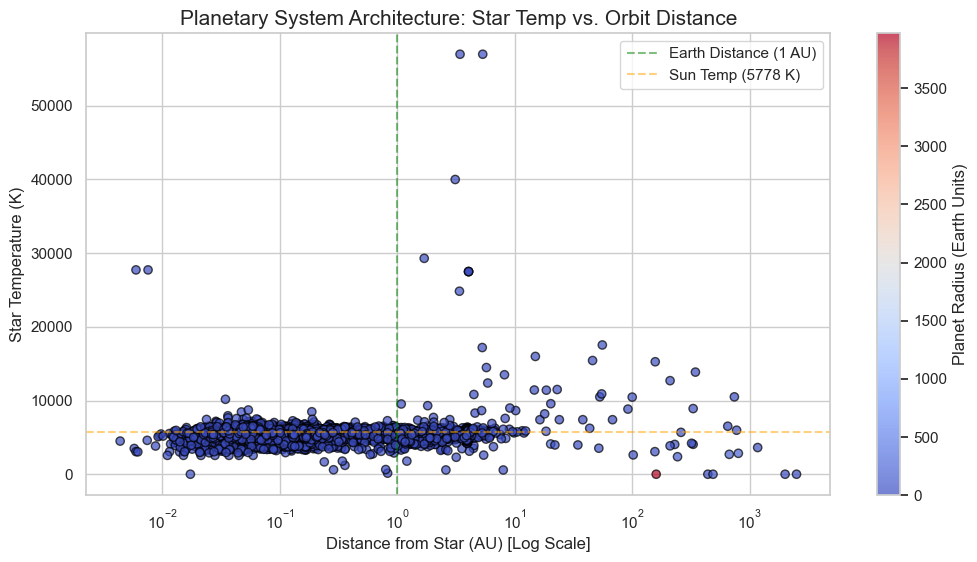

In [ ]:
# If S_TEMPERATURE (Star Temp) and P_DISTANCE (Semi-Major Axis) exist, we can infer habitability.
# Note: P_TEMP_MEASURED is often missing, so we look at the Star's heat vs Distance.

plt.figure(figsize=(12, 6))
sc = plt.scatter(df_clean['P_SEMI_MAJOR_AXIS'], df_clean['S_TEMPERATURE'], 
                 c=df_clean['P_RADIUS'], cmap='coolwarm', alpha=0.7, edgecolors='k')

plt.xscale('log')
plt.colorbar(sc, label='Planet Radius (Earth Units)')
plt.xlabel('Distance from Star (AU) [Log Scale]')
plt.ylabel('Star Temperature (K)')
plt.title('Planetary System Architecture: Star Temp vs. Orbit Distance', fontsize=15)

# Highlight Earth's position roughly
plt.axvline(x=1.0, color='green', linestyle='--', alpha=0.5, label='Earth Distance (1 AU)')
plt.axhline(y=5778, color='orange', linestyle='--', alpha=0.5, label='Sun Temp (5778 K)')
plt.legend()
plt.show()

### **4. Correlation Heatmap**
Which features move together? High correlation between Mass and Gravity is expected, but what else?

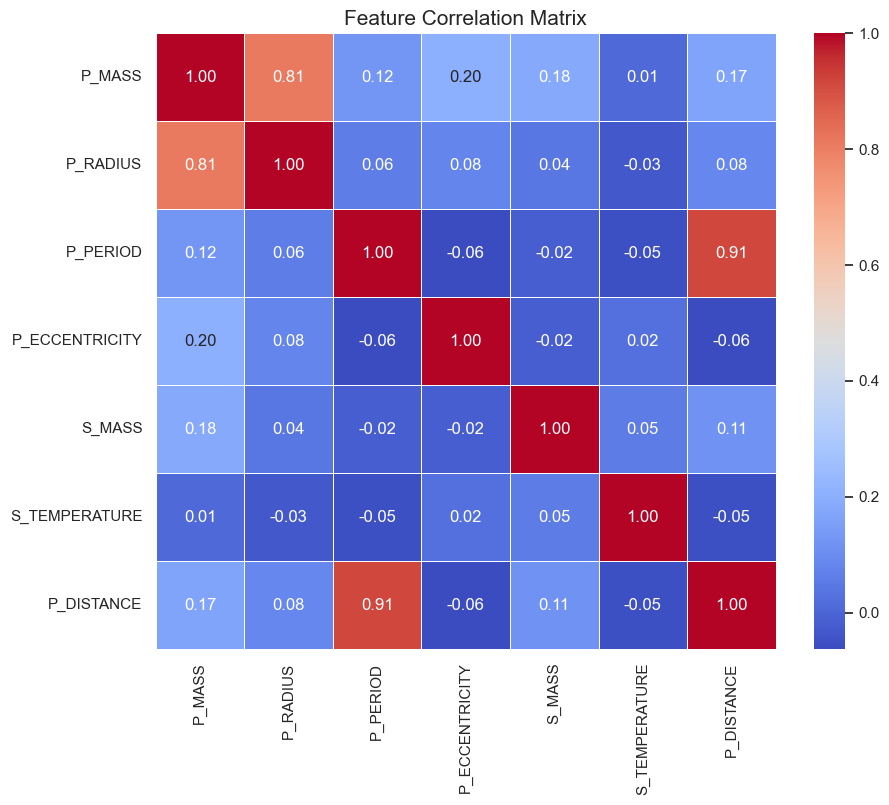

In [16]:
features_to_corr = ['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_ECCENTRICITY', 'S_MASS', 'S_TEMPERATURE', 'P_DISTANCE']
corr_matrix = df_clean[features_to_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=15)
plt.show()

### **Conclusion**
1.  **Imputation:** Successfully recovered missing data while respecting physical boundaries (Min Mass/Radius = 0).
2.  **Distributions:** Planet radii show distinct clusters (Earth-sized vs. Neptunes vs. Jupiters).
3.  **Relationships:** The Mass-Radius plot confirms the expected physical density laws of planetary formation.